--- Automating Search for Best n_neighbors ---
Successfully tested n_neighbors=5, Error: 23.9277
Successfully tested n_neighbors=7, Error: 14.6315
Successfully tested n_neighbors=9, Error: 11.5071
Successfully tested n_neighbors=11, Error: 9.2967
Successfully tested n_neighbors=13, Error: 7.4900
Successfully tested n_neighbors=15, Error: 60.6121
Successfully tested n_neighbors=17, Error: 59.4233
Successfully tested n_neighbors=19, Error: 59.6605
Successfully tested n_neighbors=21, Error: 85.2495
Successfully tested n_neighbors=23, Error: 96.6488
Successfully tested n_neighbors=25, Error: 86.7964
Successfully tested n_neighbors=27, Error: 84.1869
Successfully tested n_neighbors=29, Error: 78.3634
Successfully tested n_neighbors=31, Error: 75.2935
Successfully tested n_neighbors=33, Error: 71.9319
Successfully tested n_neighbors=35, Error: 69.5330
Successfully tested n_neighbors=37, Error: 67.5734
Successfully tested n_neighbors=39, Error: 66.4652

--- Tuning Results ---
    n_neighbors 

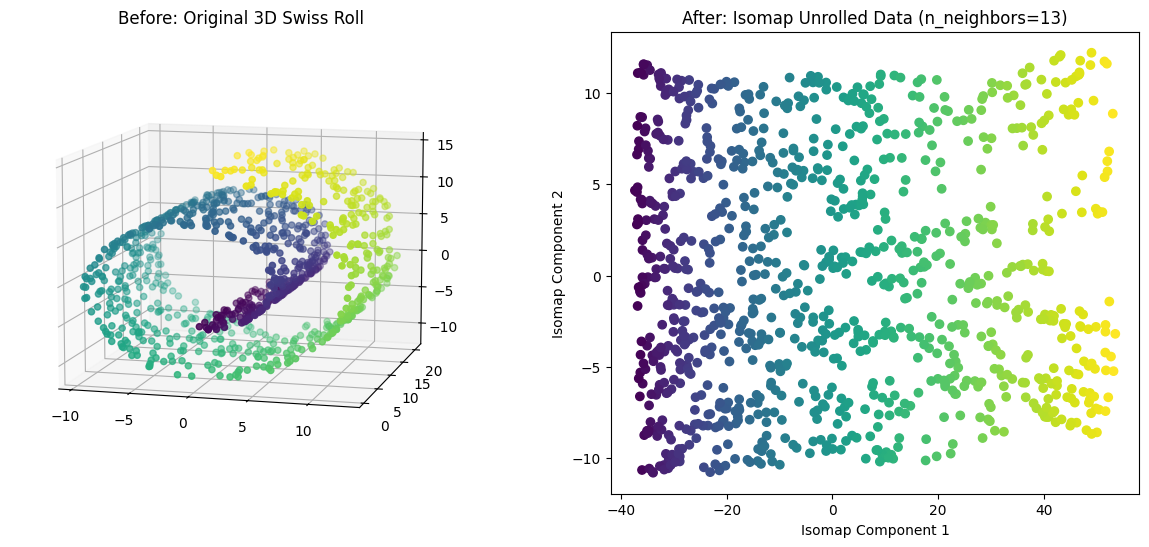

--- Final DataFrame with Isomap Components ---
   feature_1  feature_2  feature_3      color   isomap_1  isomap_2
0  -3.121175   3.887792   7.628535   8.242346 -13.653157  6.589371
1   6.125104  11.379920  12.223941  13.672660  47.469138 -2.122911
2   6.705811  18.331863  -9.479118  11.611269  21.140544 -7.747567
3  -6.191714  15.376723  -8.299438  10.354612   6.384032 -4.059958
4   6.151722  16.937784  -0.619439   6.182830 -28.828793 -5.891340


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import Isomap

# --- Load Data (Re-using from previous step) ---
X, color = make_swiss_roll(n_samples=1000, random_state=42)
df = pd.DataFrame(X, columns=['feature_1', 'feature_2', 'feature_3'])
df['color'] = color
features = ['feature_1', 'feature_2', 'feature_3']
X_data = df[features]


# --- 4. Automated Hyperparameter Tuning ---
# Instead of manually picking a value, we can automate the search for the best
# n_neighbors by finding the one that minimizes the reconstruction error.

print("--- Automating Search for Best n_neighbors ---")
tuning_results = []
# We define a range of neighbor values to test.
neighbor_range = range(5, 40, 2) # Test values from 5 to 39, step by 2

for n_neighbors in neighbor_range:
    try:
        # Initialize and fit the Isomap model
        isomap = Isomap(n_components=2, n_neighbors=n_neighbors)
        isomap.fit(X_data)
        
        # Calculate the reconstruction error and store the result
        error = isomap.reconstruction_error()
        tuning_results.append({
            'n_neighbors': n_neighbors,
            'reconstruction_error': error
        })
        print(f"Successfully tested n_neighbors={n_neighbors}, Error: {error:.4f}")

    except ValueError as e:
        # Catch errors from disconnected graphs
        if 'Number of connected components is' in str(e):
            print(f"Failed with n_neighbors={n_neighbors}: Graph has disconnected components.")
        else:
            raise e

# Convert the results to a DataFrame for easy analysis
results_df = pd.DataFrame(tuning_results)

# Find the n_neighbors value that resulted in the minimum error
best_params = results_df.loc[results_df['reconstruction_error'].idxmin()]
best_n_neighbors = int(best_params['n_neighbors'])

print("\n--- Tuning Results ---")
print(results_df)
print(f"\nBest parameter found: n_neighbors = {best_n_neighbors} with error = {best_params['reconstruction_error']:.4f}\n")


# --- 5. Apply Final Model with Automatically Found Parameter ---
# Now we apply Isomap with our algorithmically chosen hyperparameter.
final_isomap = Isomap(n_components=2, n_neighbors=best_n_neighbors)
X_transformed = final_isomap.fit_transform(X_data)

# --- 6. Visualize the Final Result ---
print("--- Visualizing Before vs. After with Optimal Parameter ---")
fig = plt.figure(figsize=(15, 6))

# Before: Original 3D data
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(df['feature_1'], df['feature_2'], df['feature_3'], c=df['color'], cmap=plt.cm.viridis)
ax1.set_title("Before: Original 3D Swiss Roll")
ax1.view_init(elev=10, azim=-75)

# After: Isomap 2D transformation
ax2 = fig.add_subplot(122)
ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], c=df['color'], cmap=plt.cm.viridis)
ax2.set_title(f"After: Isomap Unrolled Data (n_neighbors={best_n_neighbors})")
ax2.set_xlabel("Isomap Component 1")
ax2.set_ylabel("Isomap Component 2")

plt.show()

# --- 7. Store the Result in the DataFrame ---
df['isomap_1'] = X_transformed[:, 0]
df['isomap_2'] = X_transformed[:, 1]
print("--- Final DataFrame with Isomap Components ---")
print(df.head())
